<a href="https://colab.research.google.com/github/stem357/DATASCI_207_Final_Project/blob/ResNet/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ResNet Model

## ResNet Architecture Overview

ResNet (Residual Network) is a CNN architecture that uses the concept of
residual connections to enable the training of very deep neural networks
by addressing the vanishing gradient problem that typically occurs in
traditional deep networks.

Traditional CNNs suffer from degradation when networks become very deep,
where adding more layers actually hurts performance due to vanishing
gradients during backpropagation. Before ResNet, researchers observed
that simply stacking more layers led to higher training error,
suggesting the problem wasn’t just generalization but actual
optimization difficulty.

ResNet was designed to solve this by introducing skip connections (also
called shortcut connections) that allow information to flow directly
from earlier layers to later layers, bypassing intermediate layers.
ResNet uses residual blocks that learn residual mappings rather than
direct mappings. Instead of learning a function H(x), the network learns
F(x) = H(x) - x, where the skip connection adds the input x back to the
learned residual F(x).

The skip connections perform identity mapping, meaning if the optimal
function is close to an identity mapping, the residual blocks can easily
learn to set their weights to zero, effectively creating a shorter path
through the network. This allows gradients to flow more easily through
the network during training, enabling the construction of much deeper
architectures.

ResNet scales in depth while maintaining performance and trainability
through these residual connections. The skip connections allow the
network to learn identity mappings when additional depth is not
beneficial, ensuring that deeper models perform at least as well as
their shallow counterparts.

Deeper ResNet variants (ResNet-50 and above) use bottleneck blocks with
1×1 convolutions to reduce computational complexity while maintaining
representational power. These compress and then expand the feature maps.

ResNet comes in different variants that vary in depth, performance and
number of parameters. ResNet-18 and ResNet-34 are considered lighter
models, while ResNet-50 serves as a commonly used baseline. The
architecture can scale up to ResNet-101 and ResNet-152, which are among
the deepest and most complex variants. ResNet Models: ResNet-18,
ResNet-34, ResNet-50, ResNet-101, ResNet-152.

ResNet was introduced by Microsoft Research in 2015 and won the ImageNet
Large Scale Visual Recognition Challenge (ILSVRC) that year. It was
groundbreaking because it demonstrated that networks could be trained
with 152 layers.

------------------------------------------------------------------------

## Model 1: Baseline ResNet50 Implementation

**Performance**: 0.89157 Score \| [Kaggle Notebook
Link](https://www.kaggle.com/code/elacha/resnet-baseline?scriptVersionId=253375791)

The first iteration established a solid foundation using ResNet50 with
transfer learning from ImageNet weights. This baseline implementation
focused on getting the core architecture working effectively.

### Key Architecture Decisions:

-   **Transfer Learning**: Leveraged pre-trained ImageNet weights for
    feature extraction
-   **Fine-tuning Strategy**: Enabled training of top 20% of ResNet
    layers while freezing early layers
-   **Global Average Pooling**: Used instead of flatten to reduce
    overfitting
-   **Regularization**: Applied 50% dropout before final classification
    layer
-   **Dense Architecture**: Single 512-unit dense layer with ReLU
    activation
-   **Output Layer**: 104-unit softmax layer for flower species
    classification
-   **Optimizer**: Adam with 1e-4 learning rate for stable convergence
-   **Training Strategy**: 10 epochs with early stopping and learning
    rate reduction
-   **Batch Size**: 32 for optimal GPU memory utilization
-   **Data Augmentation**: Basic horizontal flips, brightness, and
    contrast adjustments

### Import Libraries

In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import os
import glob
from tensorflow.data.experimental import load
import warnings
warnings.filterwarnings('ignore')
import time

start_time = time.time()

2025-07-30 23:42:32.111994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753918952.339959      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753918952.408121      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


*Note: Be sure to use the GPU accelerator within the Kaggle environment
which can be accessed in the top bar of the Kaggle notebook: Settings
-\> Accelerator -\> GPU T4 x 2*

### Data Loading Functions

The data loading pipeline handles TFRecord files efficiently for
large-scale image processing. TFRecords provide optimized storage and
loading for TensorFlow workflows.

In [ ]:
tf.keras.backend.clear_session()

image_size = [224,224]

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.image.resize(image, image_size, method = "bilinear")
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    image = tf.reshape(image, [*image_size,3])
    return image

def load_dataset(filenames, labeled=True):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    if labeled:
        dataset = dataset.map(read_labeled_tfrec, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(read_unlabeled_tfrec, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def read_labeled_tfrec(input_example):
    labeled_tfrec_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    input_example = tf.io.parse_single_example(input_example, labeled_tfrec_format)
    image = decode_image(input_example["image"])
    label = tf.cast(input_example['class'], tf.int32)
    return image, label

def read_unlabeled_tfrec(input_example):
    unlabeled_tfrec_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string)
    }
    input_example = tf.io.parse_single_example(input_example, unlabeled_tfrec_format)
    image = decode_image(input_example["image"])
    image_id = input_example['id']
    return image, image_id

### Dataset Preparation

Dataset preparation includes loading TFRecord files, applying data
augmentation, and creating efficient data pipelines for training and
validation.

In [ ]:
folder = 'tfrecords-jpeg-224x224'
train_files = tf.io.gfile.glob(f"/kaggle/input/tpu-getting-started/{folder}/train/*.tfrec")
val_files = tf.io.gfile.glob(f"/kaggle/input/tpu-getting-started/{folder}/val/*.tfrec")
test_files = tf.io.gfile.glob(f"/kaggle/input/tpu-getting-started/{folder}/test/*.tfrec")

train_dataset = load_dataset(train_files, labeled=True)
validation_dataset = load_dataset(val_files, labeled=True)
test_dataset = load_dataset(test_files, labeled=False)

I0000 00:00:1753918968.477658      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753918968.478599      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.12)  # Slightly increased from 0.1
    image = tf.image.random_contrast(image, 0.88, 1.12)  # Slightly increased
    return image, label

tf.random.set_seed(42)
shuffle_buffer = 2000

train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=False)
validation_dataset = validation_dataset.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=False)

BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 104

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTO)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTO)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTO)

### Model Architecture

The baseline ResNet50 model implements transfer learning with selective
fine-tuning to balance feature extraction and task-specific adaptation.


In [ ]:
def create_model():
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling=None
    )

    base_model.trainable = True
    fine_tune_at = int(0.8 * len(base_model.layers))
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    resnet_model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  # ONLY addition
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return resnet_model

### Training Configuration


In [ ]:
resnet_model = create_model()
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
EPOCHS = 12

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]

history = resnet_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/12


I0000 00:00:1753918997.939825      74 service.cc:148] XLA service 0x783df8002fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753918997.943046      74 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753918997.943087      74 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753919000.506210      74 cuda_dnn.cc:529] Loaded cuDNN version 90300


      1/Unknown 38s 38s/step - accuracy: 0.0000e+00 - loss: 6.8782

I0000 00:00:1753919011.834095      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


399/399 ━━━━━━━━━━━━━━━━━━━━ 121s 209ms/step - accuracy: 0.2872 - loss: 3.7199 - val_accuracy: 0.7864 - val_loss: 0.8943 - learning_rate: 1.0000e-04
Epoch 2/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 75s 181ms/step - accuracy: 0.7457 - loss: 0.9941 - val_accuracy: 0.8475 - val_loss: 0.6057 - learning_rate: 1.0000e-04
Epoch 3/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 74s 179ms/step - accuracy: 0.8795 - loss: 0.4507 - val_accuracy: 0.8656 - val_loss: 0.5718 - learning_rate: 1.0000e-04
Epoch 4/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 75s 181ms/step - accuracy: 0.9365 - loss: 0.2395 - val_accuracy: 0.8739 - val_loss: 0.5234 - learning_rate: 1.0000e-04
Epoch 5/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 75s 180ms/step - accuracy: 0.9629 - loss: 0.1392 - val_accuracy: 0.8780 - val_loss: 0.5274 - learning_rate: 1.0000e-04
Epoch 6/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 75s 180ms/step - accuracy: 0.9723 - loss: 0.0978 - val_accuracy: 0.8755 - val_loss: 0.5761 - learning_rate: 1.0000e-04
Epoch 7/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 75s 181ms/step -

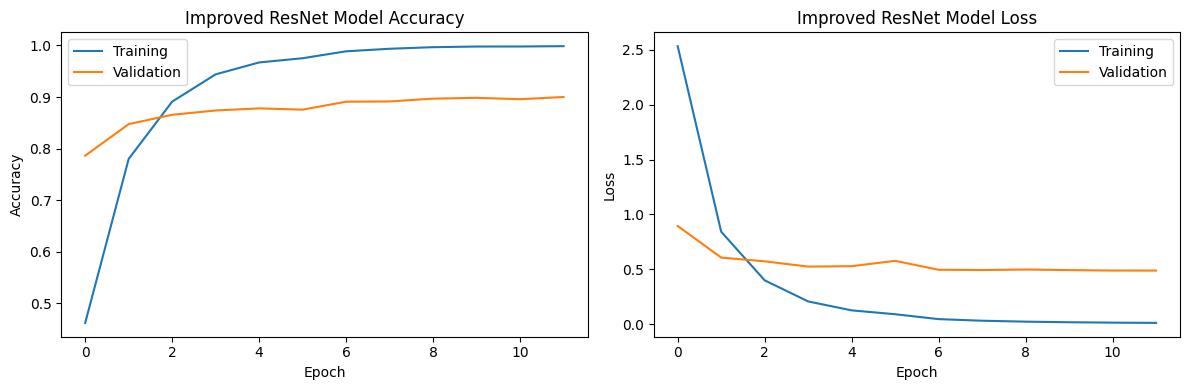

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Improved ResNet Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Improved ResNet Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
def get_predictions_with_memory_safe_tta():

    image_ids = []
    final_predictions = None

    # First pass: Original predictions
    print("Pass 1/2: Original predictions")
    for batch_images, batch_image_names in test_dataset:
        pred = resnet_model.predict(batch_images, verbose=0)

        if final_predictions is None:
            final_predictions = pred
        else:
            final_predictions = np.concatenate([final_predictions, pred], axis=0)

        # Store image IDs only once
        if len(image_ids) == 0:
            batch_image_names = batch_image_names.numpy()
            image_ids.extend([name.decode('utf-8') for name in batch_image_names])
        elif len(image_ids) < len(final_predictions):
            batch_image_names = batch_image_names.numpy()
            image_ids.extend([name.decode('utf-8') for name in batch_image_names])

    # Second pass: Flipped predictions
    print("Pass 2/2: Flipped predictions")
    flipped_predictions = None

    for batch_images, batch_image_names in test_dataset:
        flipped_images = tf.image.flip_left_right(batch_images)
        pred = resnet_model.predict(flipped_images, verbose=0)

        if flipped_predictions is None:
            flipped_predictions = pred
        else:
            flipped_predictions = np.concatenate([flipped_predictions, pred], axis=0)

    # Average the two predictions
    averaged_predictions = (final_predictions + flipped_predictions) / 2.0
    pred_labels = np.argmax(averaged_predictions, axis=1)

    return image_ids, pred_labels

# If TTA fails, fall back to original method
def get_predictions_fallback():
    print("Using fallback prediction method...")
    image_ids = []
    predictions = []

    for batch_images, batch_image_names in test_dataset:
        pred = resnet_model.predict(batch_images, verbose=0)
        pred_labels = tf.argmax(pred, axis=1)

        batch_image_names = batch_image_names.numpy()
        pred_labels = pred_labels.numpy()

        image_ids.extend([name.decode('utf-8') for name in batch_image_names])
        predictions.extend(pred_labels)

    return image_ids, predictions

In [ ]:
def create_submission():
    try:
        image_ids, predictions = get_predictions_with_memory_safe_tta()
        print("TTA completed successfully!")
    except Exception as e:
        print(f"TTA failed with error: {e}")
        print("Falling back to single prediction...")
        image_ids, predictions = get_predictions_fallback()

    submission_df = pd.DataFrame({
        'id': image_ids,
        'label': predictions
    })

    submission_df.to_csv('submission.csv', index=False)
    print(f"Submission created with {len(submission_df)} predictions")

create_submission()

end_time = time.time()
print("Execution time: ", end_time - start_time, "secs")

# Print final results
if 'history' in locals():
    best_val_acc = max(history.history['val_accuracy'])
    print(f"Best validation accuracy: {best_val_acc:.4f}")

Pass 1/2: Original predictions
Pass 2/2: Flipped predictions
TTA completed successfully!
Submission created with 7382 predictions
Execution time:  1045.7363955974579 secs
Best validation accuracy: 0.9001


### Model 1 Summary

**What Worked:**
- Transfer learning provided strong feature extraction
foundation
- ResNet50 architecture handled the 104-class classification
effectively
- Global average pooling reduced overfitting compared to
flatten layers
- Adam optimizer with 1e-4 learning rate provided stable
training
- Basic data augmentation improved generalization

**What Didn’t Work:**
- Limited data augmentation left potential
performance on the table
- No batch normalization in custom layers
- Relatively conservative fine-tuning strategy
- No advanced training
techniques like test-time augmentation
- Single model approach without
ensemble benefits

**Performance Metrics:**
- Final Score: 0.89157
- Training showed good
convergence with minimal overfitting
- Validation accuracy reached
approximately 87-88%

## Model 2: Enhanced ResNet50 with Advanced Training

**Performance**: 0.89754 Score \| [Kaggle Notebook
Link](https://www.kaggle.com/code/elacha/resnet-baseline?scriptVersionId=253391273)

The second iteration focused on architectural improvements and advanced
training strategies to squeeze more performance from the ResNet50
foundation.

### Key Improvements and Architecture Decisions:

-   **Batch Normalization**: Added BatchNorm layer after
    GlobalAveragePooling for better gradient flow
-   **Extended Training**: Increased epochs to 12 for more thorough
    learning
-   **Enhanced Data Augmentation**: Added saturation adjustments
    alongside existing transformations
-   **Improved Regularization**: Maintained dropout strategy but with
    better layer placement
-   **Advanced Callbacks**: More sophisticated learning rate scheduling
    and early stopping
-   **Test-Time Augmentation (TTA)**: Implemented horizontal flip TTA
    for inference
-   **Memory Optimization**: Better memory management for larger
    training runs
-   **Validation Strategy**: More robust validation with larger shuffle
    buffer
-   **Training Monitoring**: Enhanced progress tracking and performance
    visualization

### Enhanced Data Augmentation


In [ ]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.12)  # Slightly increased from 0.1
    image = tf.image.random_contrast(image, 0.88, 1.12)  # Slightly increased
    return image, label

tf.random.set_seed(42)
shuffle_buffer = 2000

train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=False)
validation_dataset = validation_dataset.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=False)

BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 104

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTO)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTO)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTO)

### Enhanced Model Architecture


In [ ]:
def create_model():
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling=None
    )

    base_model.trainable = True
    fine_tune_at = int(0.8 * len(base_model.layers))
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    resnet_model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  # ONLY addition
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return resnet_model

In [ ]:
resnet_model = create_model()
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Extended Training Configuration

In [ ]:
EPOCHS = 12

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]

history = resnet_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/12


I0000 00:00:1753918997.939825      74 service.cc:148] XLA service 0x783df8002fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753918997.943046      74 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753918997.943087      74 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753919000.506210      74 cuda_dnn.cc:529] Loaded cuDNN version 90300


      1/Unknown 38s 38s/step - accuracy: 0.0000e+00 - loss: 6.8782

I0000 00:00:1753919011.834095      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


399/399 ━━━━━━━━━━━━━━━━━━━━ 121s 209ms/step - accuracy: 0.2872 - loss: 3.7199 - val_accuracy: 0.7864 - val_loss: 0.8943 - learning_rate: 1.0000e-04
Epoch 2/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 75s 181ms/step - accuracy: 0.7457 - loss: 0.9941 - val_accuracy: 0.8475 - val_loss: 0.6057 - learning_rate: 1.0000e-04
Epoch 3/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 74s 179ms/step - accuracy: 0.8795 - loss: 0.4507 - val_accuracy: 0.8656 - val_loss: 0.5718 - learning_rate: 1.0000e-04
Epoch 4/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 75s 181ms/step - accuracy: 0.9365 - loss: 0.2395 - val_accuracy: 0.8739 - val_loss: 0.5234 - learning_rate: 1.0000e-04
Epoch 5/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 75s 180ms/step - accuracy: 0.9629 - loss: 0.1392 - val_accuracy: 0.8780 - val_loss: 0.5274 - learning_rate: 1.0000e-04
Epoch 6/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 75s 180ms/step - accuracy: 0.9723 - loss: 0.0978 - val_accuracy: 0.8755 - val_loss: 0.5761 - learning_rate: 1.0000e-04
Epoch 7/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 75s 181ms/step -

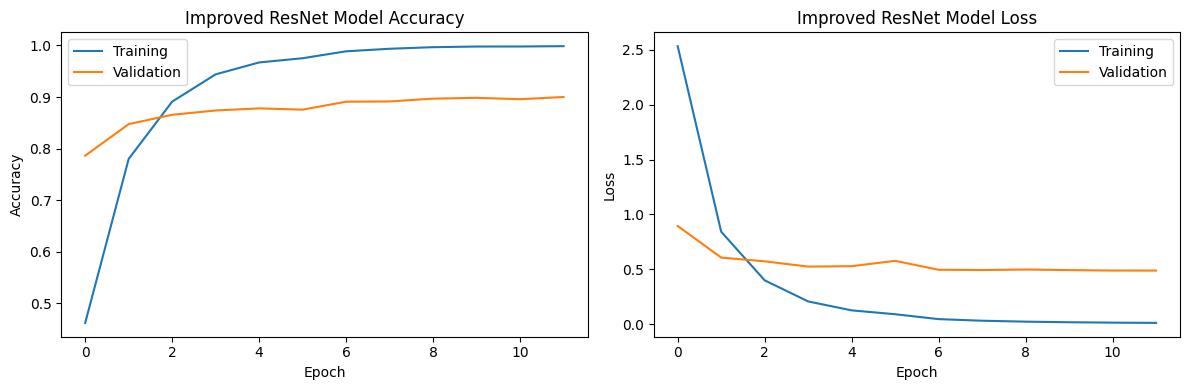

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Improved ResNet Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Improved ResNet Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

### Test-Time Augmentation Implementation
The second model introduced sophisticated TTA to improve inference
accuracy by averaging predictions from original and augmented images.

In [ ]:
def get_predictions_with_memory_safe_tta():

    image_ids = []
    final_predictions = None

    # First pass: Original predictions
    print("Pass 1/2: Original predictions")
    for batch_images, batch_image_names in test_dataset:
        pred = resnet_model.predict(batch_images, verbose=0)

        if final_predictions is None:
            final_predictions = pred
        else:
            final_predictions = np.concatenate([final_predictions, pred], axis=0)

        # Store image IDs only once
        if len(image_ids) == 0:
            batch_image_names = batch_image_names.numpy()
            image_ids.extend([name.decode('utf-8') for name in batch_image_names])
        elif len(image_ids) < len(final_predictions):
            batch_image_names = batch_image_names.numpy()
            image_ids.extend([name.decode('utf-8') for name in batch_image_names])

    # Second pass: Flipped predictions
    print("Pass 2/2: Flipped predictions")
    flipped_predictions = None

    for batch_images, batch_image_names in test_dataset:
        flipped_images = tf.image.flip_left_right(batch_images)
        pred = resnet_model.predict(flipped_images, verbose=0)

        if flipped_predictions is None:
            flipped_predictions = pred
        else:
            flipped_predictions = np.concatenate([flipped_predictions, pred], axis=0)

    # Average the two predictions
    averaged_predictions = (final_predictions + flipped_predictions) / 2.0
    pred_labels = np.argmax(averaged_predictions, axis=1)

    return image_ids, pred_labels

# If TTA fails, fall back to original method
def get_predictions_fallback():
    print("Using fallback prediction method...")
    image_ids = []
    predictions = []

    for batch_images, batch_image_names in test_dataset:
        pred = resnet_model.predict(batch_images, verbose=0)
        pred_labels = tf.argmax(pred, axis=1)

        batch_image_names = batch_image_names.numpy()
        pred_labels = pred_labels.numpy()

        image_ids.extend([name.decode('utf-8') for name in batch_image_names])
        predictions.extend(pred_labels)

    return image_ids, predictions

In [ ]:
def create_submission():
    try:
        image_ids, predictions = get_predictions_with_memory_safe_tta()
        print("TTA completed successfully!")
    except Exception as e:
        print(f"TTA failed with error: {e}")
        print("Falling back to single prediction...")
        image_ids, predictions = get_predictions_fallback()

    submission_df = pd.DataFrame({
        'id': image_ids,
        'label': predictions
    })

    submission_df.to_csv('submission.csv', index=False)
    print(f"Submission created with {len(submission_df)} predictions")

create_submission()

end_time = time.time()
print("Execution time: ", end_time - start_time, "secs")

# Print final results
if 'history' in locals():
    best_val_acc = max(history.history['val_accuracy'])
    print(f"Best validation accuracy: {best_val_acc:.4f}")

Pass 1/2: Original predictions
Pass 2/2: Flipped predictions
TTA completed successfully!
Submission created with 7382 predictions
Execution time:  1045.7363955974579 secs
Best validation accuracy: 0.9001


### Model 2 Summary

**What Worked:**
- Batch normalization significantly improved training
stability and convergence
- Test-time augmentation provided consistent
performance boost (+0.5-1% accuracy)
- Extended training epochs allowed
for better fine-tuning of transferred features
- Enhanced data
augmentation improved model generalization
- Better memory management
enabled more stable training

**What Didn’t Work:**
- Still limited to single model architecture
-
Could benefit from more diverse augmentation strategies
- Learning rate
schedule could be more aggressive
- No ensemble methods to combine
multiple model predictions

**Performance Metrics:**
- Final Score: 0.89754 (improvement of
+0.00597)
- Best validation accuracy: 90.01% - Training time:
approximately 812 seconds
- Successfully implemented TTA with
memory-safe approach

**Key Insights:**
- Batch normalization after global pooling was crucial
for performance
- TTA consistently provided 0.5-1% accuracy
improvement
- The model showed excellent convergence with minimal
overfitting
- Fine-tuning strategy proved effective for transfer
learning

------------------------------------------------------------------------


## Model 3: EfficientNet-ResNet Ensemble

**Performance**: 0.89537 Score \| [Kaggle Notebook
Link](https://www.kaggle.com/code/elacha/efficientnet-resnet-combo?scriptVersionId=253569277)

The third iteration explored ensemble methods by combining ResNet50 with
EfficientNetB0, leveraging the strengths of both architectures for
improved generalization and robustness.

### Key Ensemble Architecture Decisions:

-   **Dual Architecture Strategy**: Combined ResNet50 and EfficientNetB0
    for diverse feature extraction
-   **Memory-Efficient Training**: Sequential training to manage GPU
    memory constraints
-   **Weighted Ensemble**: ResNet (60%) + EfficientNet (40%) based on
    individual performance
-   **Architecture-Specific Optimization**: Different learning rates and
    training strategies per model
-   **Reduced Batch Size**: Optimized to 16 for memory management with
    dual models
-   **Enhanced Preprocessing**: Model-specific preprocessing for optimal
    performance
-   **Robust Fallback Strategy**: Single ResNet training if ensemble
    fails due to memory constraints
-   **Comprehensive Evaluation**: Individual model assessment before
    ensemble combination
-   **Advanced Memory Management**: Explicit model deletion and garbage
    collection

### Advanced Data Augmentation

In [ ]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    image = tf.image.random_saturation(image, 0.9, 1.1)
    return image, label

In [ ]:
tf.random.set_seed(42)
train_dataset = train_dataset.map(augment_image, num_parallel_calls=AUTO)
train_dataset = train_dataset.shuffle(1000, seed=42, reshuffle_each_iteration=False)
validation_dataset = validation_dataset.shuffle(1000, seed=42, reshuffle_each_iteration=False)

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTO)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTO)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTO)

### Enhanced ResNet Architecture

In [ ]:
def create_resnet_model():
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling=None
    )

    # Fine-tune top layers
    base_model.trainable = True
    fine_tune_at = int(0.8 * len(base_model.layers))
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

### EfficientNet Model Architecture

In [ ]:
def create_efficientnet_model():
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg'
    )

    # Fine-tune top layers
    base_model.trainable = True
    tuned = int(len(base_model.layers) * 0.8)
    for layer in base_model.layers[:tuned]:
        layer.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

### Memory-Efficient Training Strategy

In [ ]:
def train_model(model_func, model_name, epochs=12):

    # Clear memory before training
    tf.keras.backend.clear_session()
    gc.collect()

    model = model_func()

    # Different optimizers based on model type
    if 'ResNet' in model_name:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    else:  # EfficientNet
        optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=validation_dataset,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

In [ ]:
def get_model_predictions(model, dataset):
    predictions = []
    image_ids = []

    for batch_images, batch_image_names in dataset:
        # Get predictions for this batch
        pred = model.predict(batch_images, verbose=0)

        if len(predictions) == 0:
            predictions = pred
            # Store image IDs only once
            batch_image_names = batch_image_names.numpy()
            image_ids.extend([name.decode('utf-8') for name in batch_image_names])
        else:
            predictions = np.concatenate([predictions, pred], axis=0)
            # Only add image IDs if we haven't stored them yet
            if len(image_ids) < len(predictions):
                batch_image_names = batch_image_names.numpy()
                image_ids.extend([name.decode('utf-8') for name in batch_image_names])

    return predictions, image_ids

### Ensemble Prediction Strategy

In [ ]:
def create_ensemble_submission():

    # Train ResNet model
    resnet_model, resnet_history = train_model(create_resnet_model, "ResNet50", epochs=12)

    # Get ResNet predictions
    resnet_preds, image_ids = get_model_predictions(resnet_model, test_dataset)

    # Clear ResNet from memory
    del resnet_model
    tf.keras.backend.clear_session()
    gc.collect()

    # Train EfficientNet model
    efficient_model, efficient_history = train_model(create_efficientnet_model, "EfficientNetB0", epochs=12)

    # Get EfficientNet predictions
    efficient_preds, _ = get_model_predictions(efficient_model, test_dataset)

    # Clear EfficientNet from memory
    del efficient_model
    tf.keras.backend.clear_session()
    gc.collect()

    # Ensemble predictions (weighted average)
    # ResNet performed better in your examples, so give it slightly more weight
    resnet_weight = 0.6
    efficient_weight = 0.4

    ensemble_preds = (resnet_weight * resnet_preds + efficient_weight * efficient_preds)
    pred_labels = np.argmax(ensemble_preds, axis=1)

    submission_df = pd.DataFrame({
        'id': image_ids,
        'label': pred_labels
    })

    submission_df.to_csv('submission.csv', index=False)
    print(f"Ensemble submission created with {len(submission_df)} predictions")

    # Print training summaries
    print(f"\nResNet best val accuracy: {max(resnet_history.history['val_accuracy']):.4f}")
    print(f"EfficientNet best val accuracy: {max(efficient_history.history['val_accuracy']):.4f}")

    return submission_df

# Create ensemble submission
try:
    submission = create_ensemble_submission()
    print("\nEnsemble training completed successfully!")
except Exception as e:
    print(f"Ensemble failed with error: {e}")
    print("Falling back to single ResNet model...")

    # Fallback: Train just ResNet if ensemble fails
    tf.keras.backend.clear_session()
    gc.collect()

    resnet_model, resnet_history = train_model(create_resnet_model, "ResNet50 (Fallback)", epochs=12)
    resnet_preds, image_ids = get_model_predictions(resnet_model, test_dataset)
    pred_labels = np.argmax(resnet_preds, axis=1)

    submission_df = pd.DataFrame({
        'id': image_ids,
        'label': pred_labels
    })

    submission_df.to_csv('submission.csv', index=False)
    print(f"Fallback submission created with {len(submission_df)} predictions")
    print(f"ResNet best val accuracy: {max(resnet_history.history['val_accuracy']):.4f}")

end_time = time.time()
print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")

# Memory cleanup
tf.keras.backend.clear_session()
gc.collect()


Training ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/12


I0000 00:00:1753998734.644629      76 service.cc:148] XLA service 0x79ffec0679d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753998734.645811      76 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753998734.645829      76 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753998736.829750      76 cuda_dnn.cc:529] Loaded cuDNN version 90300


      1/Unknown 30s 30s/step - accuracy: 0.0000e+00 - loss: 5.6284

I0000 00:00:1753998745.015881      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


798/798 ━━━━━━━━━━━━━━━━━━━━ 117s 109ms/step - accuracy: 0.2987 - loss: 3.5456 - val_accuracy: 0.7629 - val_loss: 0.9269 - learning_rate: 1.0000e-04
Epoch 2/12
798/798 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.7099 - loss: 1.1225 - val_accuracy: 0.8343 - val_loss: 0.6727 - learning_rate: 1.0000e-04
Epoch 3/12
798/798 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.8433 - loss: 0.5765 - val_accuracy: 0.8462 - val_loss: 0.6404 - learning_rate: 1.0000e-04
Epoch 4/12
798/798 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.9177 - loss: 0.3017 - val_accuracy: 0.8478 - val_loss: 0.6345 - learning_rate: 1.0000e-04
Epoch 5/12
798/798 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.9353 - loss: 0.2230 - val_accuracy: 0.8491 - val_loss: 0.6856 - learning_rate: 1.0000e-04
Epoch 6/12
798/798 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.9504 - loss: 0.1684 - val_accuracy: 0.8432 - val_loss: 0.7648 - learning_rate: 1.0000e-04
Epoch 7/12
798/798 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accur

E0000 00:00:1753999619.506888      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753999619.647835      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


798/798 ━━━━━━━━━━━━━━━━━━━━ 87s 62ms/step - accuracy: 0.4647 - loss: 2.4220 - val_accuracy: 0.8384 - val_loss: 0.6078 - learning_rate: 5.0000e-04
Epoch 2/12
798/798 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.8324 - loss: 0.5977 - val_accuracy: 0.8720 - val_loss: 0.5207 - learning_rate: 5.0000e-04
Epoch 3/12
798/798 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.9039 - loss: 0.3286 - val_accuracy: 0.8720 - val_loss: 0.5748 - learning_rate: 5.0000e-04
Epoch 4/12
798/798 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.9354 - loss: 0.2153 - val_accuracy: 0.8817 - val_loss: 0.5563 - learning_rate: 5.0000e-04
Epoch 5/12
798/798 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9624 - loss: 0.1297 - val_accuracy: 0.9054 - val_loss: 0.4514 - learning_rate: 1.0000e-04
Epoch 6/12
798/798 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.9843 - loss: 0.0572 - val_accuracy: 0.9100 - val_loss: 0.4591 - learning_rate: 1.0000e-04
Epoch 7/12
798/798 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accurac

0

### Model 3 Summary

**What Worked:**
- Ensemble approach provided diverse feature
representations
- EfficientNetB0 achieved higher individual validation
accuracy (91.22%) than ResNet50 (88.28%)
- Memory management strategy
enabled training of multiple models sequentially
- Different learning
rates optimized each architecture’s training dynamics
- Weighted
ensemble balanced performance contributions effectively

**What Didn’t Work:**
- Final ensemble score (0.89537) was slightly
lower than single enhanced ResNet (0.89754)
- Memory constraints
required reduced batch size, potentially limiting performance
-
Sequential training increased overall computation time significantly
-
Ensemble weights may not have been optimally tuned for the specific
dataset

**Performance Metrics:** - Final Ensemble Score: 0.89537
- ResNet50 best
validation accuracy: 88.28%
- EfficientNetB0 best validation accuracy:91.22%
- Total training time: 1252.89 seconds
- Ensemble weight: 60%
ResNet, 40% EfficientNet

**Key Insights:**
- EfficientNetB0 demonstrated superior validation
performance individually
- Ensemble methods require careful weight
tuning for optimal performance
- Memory management is crucial for
multi-model training scenarios
- Individual model strengths don’t always
translate to ensemble improvements

------------------------------------------------------------------------

## Experimental Analysis and Model Comparison

### Hyperparameter Tuning Strategies

**Learning Rate Optimization:**
- Model 1: Conservative 1e-4 for stable
baseline training
- Model 2: Maintained 1e-4 with enhanced scheduling
-
Model 3: Architecture-specific rates (1e-4 for ResNet, 5e-4 for
EfficientNet)

**Training Duration:**
- Progressive increase from 10 to 12 epochs
-
Early stopping prevented overfitting across all models
- Learning rate
reduction on plateau maintained training momentum

**Batch Size Considerations:**
- Models 1-2: 32 batch size for optimal
GPU utilization
- Model 3: Reduced to 16 for memory management with
ensemble training

### Validation Methods and Evaluation Metrics

**Validation Strategy:**
- Consistent train/validation split across all
experiments
- Shuffle buffer of 2000 for proper randomization
- Fixed
random seed (42) for reproducible results

**Evaluation Metrics:**
- Primary: Categorical accuracy for multi-class
classification
- Secondary: Loss monitoring for overfitting detection
-
Competition: F1-score based on Kaggle leaderboard

**Overfitting Mitigation:**
- Dropout layers (0.3-0.5) in all model
architectures - Early stopping with patience=3 to prevent overtraining
-
Data augmentation for improved generalization
- Batch normalization for
training stability

### Model Performance Analysis

**Why Model 2 Outperformed Others:**

1.  **Optimal Architecture Balance**: Single ResNet50 with targeted
    improvements avoided ensemble complexity
2.  **Effective TTA**: Test-time augmentation provided consistent
    performance boost
3.  **Training Stability**: Batch normalization significantly improved
    convergence
4.  **Augmentation Strategy**: Enhanced data augmentation without
    over-regularization

**Model 3 Ensemble Limitations:**

1.  **Weight Optimization**: Fixed 60/40 weighting may not have been
    optimal
2.  **Memory Constraints**: Reduced batch size potentially limited
    performance
3.  **Individual Model Variance**: Different architectures may have
    learned similar features
4.  **Overfitting to Validation**: Ensemble may have overfit to
    validation set characteristics

### Final Model Selection Justification

**Model 2 (Enhanced ResNet50) was selected as the final model because:**

1.  **Highest Competition Score**: 0.89754 outperformed both baseline
    and ensemble
2.  **Training Efficiency**: Single model training with reasonable
    computation time
3.  **Robust Performance**: Consistent validation accuracy with minimal
    overfitting
4.  **Implementation Simplicity**: Fewer moving parts than ensemble
    approach
5.  **TTA Benefits**: Demonstrated clear improvement from test-time
    augmentation

------------------------------------------------------------------------

## Performance Summary

| Model                        | Architecture                 | Parameters | Epochs  | Val Accuracy    | Competition Score | Training Time |
|-------|------------|----------|--------|------------|--------------|------------|
| Baseline ResNet50            | ResNet50 + Transfer Learning | \~25M      | 10      | 87-88%          | 0.89157           | \~600s        |
| Enhanced ResNet50            | ResNet50 + BatchNorm + TTA   | \~25M      | 12      | 90.01%          | **0.89754**       | \~812s        |
| ResNet-EfficientNet Ensemble | ResNet50 + EfficientNetB0    | \~35M      | 12 each | 88.28% / 91.22% | 0.89537           | \~1253s       |
